In [2]:
%env DB_PATH=../../../data/db/srs.db
from db import *
from api.routers.rolls import get_roll
from sqlalchemy import insert, select
    
import pandas as pd
import numpy as np
from garmin_fit_sdk import Decoder, Stream
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from util import lowpass_filter
FIT_EPOCH_S = 631065600
DATA_PATH = '../../../data'

env: DB_PATH=../../../data/db/srs.db


In [3]:
with Session(engine) as session:
    roll = get_roll(6, session)

In [4]:
fit = [f for f in roll.roll_files if f.type == 'fit'][0]
path = fit.uri.replace("%fit%/", f'{DATA_PATH}/virbs/')
stream = Stream.from_file(path)
decoder = Decoder(stream)
messages, errors = decoder.read(convert_datetimes_to_dates=False)
errors

[]

In [5]:
starts = [m for m in messages['camera_event_mesgs'] if m['camera_event_type'] == 'video_start']
if len(starts) != 1:
    raise ValueError(f"Found {len(starts)} video start events")
start = starts[0]
start_time = start['timestamp'] * 1000 + start['timestamp_ms']
start_time

3164

In [6]:
gps_mesgs = messages['gps_metadata_mesgs']
gps_data = pd.DataFrame.from_records(gps_mesgs)
gps_data['utc_timestamp'] = pd.to_datetime((gps_data.utc_timestamp + FIT_EPOCH_S) * 1e9)
gps_data.index = (gps_data.timestamp * 1000 + gps_data.timestamp_ms) - start_time
gps_data['timestamp'] = gps_data.index / 1000.0
gps_data.position_lat = gps_data.position_lat / 2**31 * 180
gps_data.position_long = gps_data.position_long / 2**31 * 180
gps_data.head()

,timestamp,position_lat,position_long,enhanced_altitude,enhanced_speed,utc_timestamp,timestamp_ms,heading,velocity,8,9,10,11,12
4747,4.747,40.441737,-79.941467,286.6,0.0,2025-09-21 12:26:26,911,175.38,"[-0.04, -0.38, 0.08]",113,95,148,92,129
4847,4.847,40.441734,-79.941466,286.4,0.0,2025-09-21 12:26:26,11,175.38,"[-0.02, -0.23, 0.08]",109,92,143,92,129
4947,4.947,40.441730,-79.941463,286.8,0.0,2025-09-21 12:26:26,111,175.38,"[-0.02, -0.19, 0.07]",105,88,137,92,129
5047,5.047,40.441728,-79.941459,287.2,0.0,2025-09-21 12:26:26,211,175.38,"[-0.02, -0.2, 0.05]",101,85,132,92,129
5147,5.147,40.441725,-79.941457,287.6,0.0,2025-09-21 12:26:26,311,175.38,"[-0.2, 0.23, 0.04]",97,83,128,92,129


In [7]:
px.line(gps_data.enhanced_speed)

In [8]:
#remove white outline around points
px.scatter(gps_data, x='position_long', y='position_lat', color='timestamp', size='enhanced_speed', size_max=10)

In [9]:
import json
with open(f'../../../tmp/{path.split('/')[-1].replace(".fit", ".json")}', 'w') as f:
    json.dump(messages, f, indent=2, default=str)

# Geo

In [7]:
import rasterio
from pyproj import Transformer

In [8]:
elevation = rasterio.open(f'{DATA_PATH}/geo/output_USGS1m.tif')

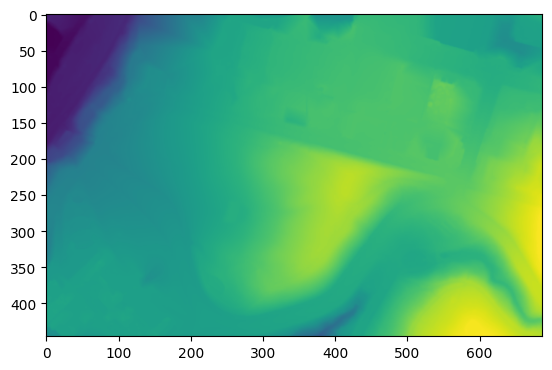

In [9]:
# show elevation data as image
elevation_data = elevation.read(1)
plt.imshow(elevation_data, cmap='viridis')

In [10]:
transformer = Transformer.from_crs("epsg:4326", elevation.crs)
locs = transformer.transform(gps_data.position_lat.values, gps_data.position_long.values)
# get ele

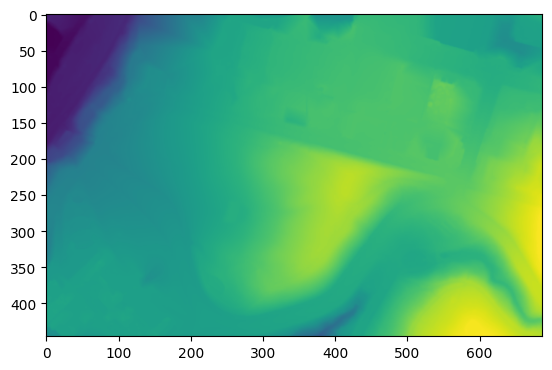

In [11]:
plt.imshow(elevation_data, cmap='viridis')

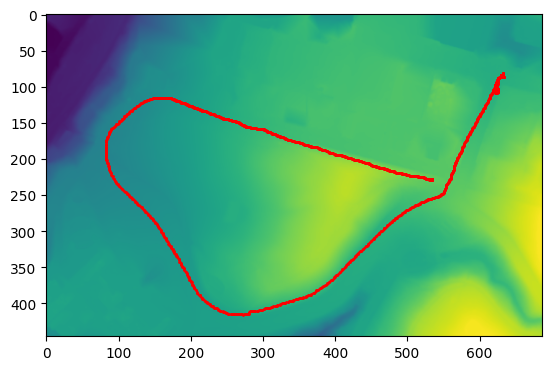

In [ ]:
point_list = [elevation.index(x, y) for x, y in zip(locs[0], locs[1])]
points = pd.DataFrame.from_records([{'col': p[1], 'row': p[0]} for p in point_list])
plt.imshow(elevation_data, cmap='viridis')
plt.scatter(x=points.col, y=points.row, c='red', s=1)

In [13]:
elevations = [e[0] for e in elevation.sample(zip(locs[0], locs[1]))]
len(elevations)

2544

In [14]:
gps_data['elevations'] = elevations
px.line(gps_data, y='elevations')

In [101]:
# plot energy and enhanced_speed with seperate y axis
energy = gps_data.enhanced_speed ** 2 + gps_data.elevations * 9.81

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=energy, name="energy (J/kg)"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=gps_data.index / 1000.0, y=gps_data.enhanced_speed, name="enhanced_speed (m/s)"),
    secondary_y=True,
)
fig.show()

In [99]:
px.line(energy, )

## 3D

In [80]:
stride = 3
elevation_xyz = pd.DataFrame.from_records([
    {'y': i * stride, 'x': j * stride, 'elevation': e} 
    for j, row in enumerate(elevation_data[::stride])
        for i, e in enumerate(row[::stride])
])
elevation_xyz


,y,x,elevation
0,0,0,254.089035
1,3,0,254.092361
2,6,0,254.098526
3,9,0,254.102814
4,12,0,254.112122
...,...,...,...
34116,672,444,306.029633
34117,675,444,305.855835
34118,678,444,305.734558
34119,681,444,305.683075


In [93]:
fig = go.Figure(data=[go.Scatter3d(
    x=elevation_xyz.x,
    y=elevation_xyz.y,
    z=elevation_xyz.elevation,
    mode='markers',
    marker=dict(
        size=3,
        color=elevation_xyz.elevation,                
        colorscale='Viridis',   
        opacity=1
    ),
)])

# fig = go.Figure(data=[go.Mesh3d(
#     x=elevation_xyz.x,
#     y=elevation_xyz.y,
#     z=elevation_xyz.elevation,
#     color='gray',
# )])
max_e = elevation_xyz.elevation.max()
fig.update_layout(
    width=1000, 
    height=400,
    margin=dict(l=0, r=0, t=0, b=0),
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=3, y=3, z=1),
        zaxis=dict(range=[max_e * 0.75, max_e * 1.1])
    )
)
fig.add_trace(go.Scatter3d(x=points.row, y=points.col, z=elevations,
                           mode='markers', 
                           marker=dict(size=5, color=points.index, colorscale='Hot')))
fig.show()

In [85]:
points

,col,row
0,631,85
1,632,85
2,632,86
3,632,86
4,632,86
...,...,...
2539,534,228
2540,533,228
2541,533,228
2542,533,228
